<h2> Load Data</h2>

In [1]:
import warnings
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd
import regex as re
import preparers
import sonaion_analysis as son
import GenSnippetsLib as snippet
import behavioral as bh
import os
import seaborn as sns
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

<h2>potential funtion arguments</h2>

In [2]:
def get_line_bounds(img, image_path):
    height = img.size[1]
    with open(image_path) as json_file:
        data = json.load(json_file)
        height_margin = data["height-margin"]
        loc = len(data["source-code"])
        height = height - 2 * height_margin

    step_size = height/loc
    bounds = []
    for i in range(loc):
        lower = int(i*step_size) + height_margin
        higher = int((i+1)*step_size) + height_margin
        bounds.append((i, lower, higher))

    return bounds

In [3]:
fig, ax = (None, None)
denoise_degree = 10
display_width = 1920
display_height = 1080
left_color = (0.0, 1.0, 1.0)
right_color = (0.0, 1.0, 0.0)
image_path = "../CodeSnippets/Generators/" + "BogoSort" + ".json"
img, result = snippet.create_image(image_path, font_path="/../CodeSnippets/fonts/ttf/")
offset = int(display_height*0.5-img.size[1]*0.5)
img_bounds = get_line_bounds(img, image_path)
img_bounds = [(i, low + offset, high + offset) for i, low, high in img_bounds]
loc = len(img_bounds)
line_middle = [int((low+height)/2) for i, low, height in img_bounds]
bg = snippet.create_background(display_width, display_height, (180, 180, 180, 255))
img = snippet.place_image_on(bg, np.array(img), 0.5, 0.5)
cat = np.full(display_height, None)
for i, low, height in img_bounds:
    for j in range(low, height):
        cat[j] = i

## Get Group Values

In [187]:
def group(row):
    if row["yearsOfProgramming"] >= 7.0 and row["yearsOfJava"] >= 2.0:
        return  "expert"
    if row["yearsOfProgramming"] <= 2.0:
        return  "novice"
    return "middle"

In [355]:
df_questionnaire = pd.read_excel("./rawData/Questionnaire.xlsx", sheet_name="Experience")
# transpose the dataframe
df_questionnaire = df_questionnaire.transpose()
# use first row as column names
df_questionnaire.columns = df_questionnaire.iloc[0]
#delete first row
df_questionnaire = df_questionnaire.drop(df_questionnaire.index[0])
#drop row where years of programming is missing
df_questionnaire = df_questionnaire.dropna(subset=["yearsAtWork"])
#change all NaN to 0
df_questionnaire = df_questionnaire.fillna(0)

# drop row with "Participant" beeing 9
df_questionnaire = df_questionnaire.drop(9)

#classify all particiapnts into two groups:
#1. those with yearsOfProgramming >= 7 and yearsOfJava >= 2 as "experts"
#2. those with yearsOfProgramming < 7 and yearsOfJava < 2 as "novices"
df_questionnaire["yearsOfProgramming"] = df_questionnaire["yearsOfProgramming"].astype(float)
df_questionnaire["yearsOfJava"] = df_questionnaire["yearsOfJava"].astype(float)
df_questionnaire["group"] = df_questionnaire.apply(lambda x: "experts" if x["yearsOfProgramming"] >= 7.0 and x["yearsOfJava"] >= 2.0 else "novice", axis=1)
#df_questionnaire["group"] = df_questionnaire.apply(lambda x: group(x), axis=1)
df_questionnaire[["yearsOfProgramming", "yearsOfJava", "group"]]

Participant,yearsOfProgramming,yearsOfJava,group
1,7.0,6.0,experts
2,6.0,4.0,novice
3,10.0,4.0,experts
4,7.0,7.0,experts
5,8.0,0.0,novice
6,20.0,10.0,experts
7,7.0,7.0,experts
10,7.0,7.0,experts
11,8.0,4.0,experts
12,7.0,5.0,experts


In [356]:
# calulate the pearson correlation between the years of programming and the years of java
corr = df_questionnaire.corr(method="pearson")
corr

Participant,yearsOfProgramming,yearsOfProfessionalProgramming,yearsOfJava,logicalExperience,functionalExperience,imperativExperience,objectExperience,comparedToStudent,comparedToProfessional
Participant,,,,,,,,,
yearsOfProgramming,1.000000,0.912879,0.834671,0.196881,0.277054,0.298009,0.405389,-0.155277,0.222305
yearsOfProfessionalProgramming,0.912879,1.000000,0.755738,0.162842,0.153438,0.211286,0.451542,-0.067585,0.287723
yearsOfJava,0.834671,0.755738,1.000000,0.107167,0.313488,0.186688,0.348047,-0.123541,0.267995
logicalExperience,0.196881,0.162842,0.107167,1.000000,0.438185,0.364237,0.112319,0.161150,0.299794
functionalExperience,0.277054,0.153438,0.313488,0.438185,1.000000,0.311776,0.099272,0.019113,0.308248
imperativExperience,0.298009,0.211286,0.186688,0.364237,0.311776,1.000000,0.393788,-0.083585,0.211158
objectExperience,0.405389,0.451542,0.348047,0.112319,0.099272,0.393788,1.000000,0.078476,0.393626
comparedToStudent,-0.155277,-0.067585,-0.123541,0.161150,0.019113,-0.083585,0.078476,1.000000,0.496090
comparedToProfessional,0.222305,0.287723,0.267995,0.299794,0.308248,0.211158,0.393626,0.496090,1.000000


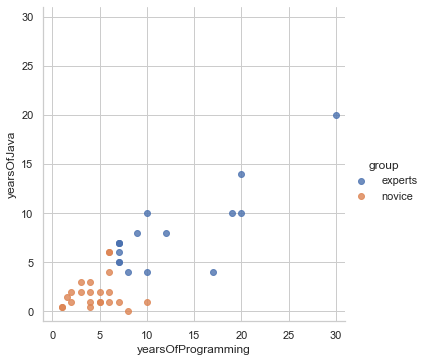

In [357]:
# do k means clustering on the dataframe to get the groups of the participants based on yearsOfProgramming and yearsOfJava
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0).fit(df_questionnaire[["yearsOfProgramming", "yearsOfJava"]])
# df_questionnaire["group"] = kmeans.labels_
# do a scatterplot based on yearsOfProgramming and yearsOfJava
sns.set(style="whitegrid")
g = sns.lmplot(x="yearsOfProgramming", y="yearsOfJava", data=df_questionnaire, hue="group", fit_reg=False)
g.set(ylim=(-1, 31))
g.set(xlim=(-1, 31))

In [358]:
#df_questionnaire.loc[df_questionnaire["group"] == 0, "group"] = "middle"
#df_questionnaire.loc[df_questionnaire["group"] == 1, "group"] = "experts"
#df_questionnaire.loc[df_questionnaire["group"] == 2, "group"] = "novices"

In [359]:
participants = []
snippets = []
for sub_dirs in list(os.walk("./filteredData"))[0][1]:
    participants.append(int(re.findall(r'\d+', sub_dirs)[0]))

df_behavioral = bh.get_behavioral_df(participants)

In [360]:
#transform the response field, so that "Right" will be "Right" and everything else will be "Wrong"
df_behavioral["Response"] = df_behavioral["Response"].apply(lambda x: "Right" if x == "Right" else "Wrong")

In [361]:
#add a group column that classifies the participants into "novices" and "experts" based on  the groups in df_questionnaire
df_behavioral["group"] = df_questionnaire["group"]
df_behavioral["experience"] = df_questionnaire["yearsOfProgramming"]
df_behavioral

,Duration,Response,Snippet,group,experience
Participant,,,,,
1,27.286223,Wrong,Ackerman,experts,7.0
1,23.420816,Wrong,ArrayAverage,experts,7.0
1,49.922091,Right,BinToDecimal,experts,7.0
1,47.770645,Wrong,BinarySearch,experts,7.0
1,82.632721,Wrong,BinomialCoefficient,experts,7.0
...,...,...,...,...,...
71,35.637456,Right,SiebDesEratosthenes,novice,2.0
71,16.485685,Right,SignChecker,novice,2.0
71,18.607310,Right,SmallGauss,novice,2.0


In [279]:
# count novicies and experts and middle
df_questionnaire["group"].value_counts()

novice     22
experts    16
Name: group, dtype: int64

In [362]:
# calculate the quantile of the Duration field for each group and add it to the dataframe
# df_behavioral = df_behavioral[df_behavioral["Response"]=="Right"]
novices_lower = df_behavioral[df_behavioral["group"] == "novice"]["Duration"].quantile(0.05)
novices_upper = df_behavioral[df_behavioral["group"] == "novice"]["Duration"].quantile(0.95)

experts_lower = df_behavioral[df_behavioral["group"] == "experts"]["Duration"].quantile(0.05)
experts_upper = df_behavioral[df_behavioral["group"] == "experts"]["Duration"].quantile(0.95)

# kick out all participants that are not in the lower or upper quantile
df_novices = df_behavioral[(df_behavioral["group"] == "novice") & (df_behavioral["Duration"] >= novices_lower) & (df_behavioral["Duration"] <= novices_upper)]
df_experts = df_behavioral[(df_behavioral["group"] == "experts") & (df_behavioral["Duration"] >= experts_lower) & (df_behavioral["Duration"] <= experts_upper)]
# merge dataframes
df_behavioral = pd.concat([df_novices, df_experts])

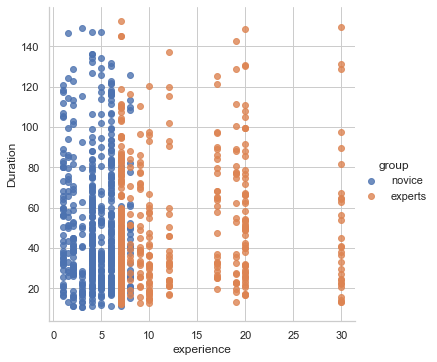

In [363]:
#create a violin plot comparing the Duration of novices and experts
sns.lmplot(x="experience", y="Duration", data=df_behavioral, hue="group", fit_reg=False)

In [364]:
# get the total time of the experiment per participant
participants = []
for sub_dirs in list(os.walk("./rawData"))[0][1]:
    participants.append(int(re.findall(r'\d+', sub_dirs)[0]))

df_times = pd.DataFrame(columns=["Participant", "totalTime"])
for participant in participants:
    participant_folder = "./rawData/Participant{}/".format(str(participant).zfill(2))
    psychopy_csv_path = participant_folder

    # get path for psychopy log and csv data
    for (dirpath, dirnames, filenames) in os.walk(psychopy_csv_path):
        for file in filenames:
            file, ext = os.path.splitext(file)
            if ext == ".csv" and "test" in file:
                psychopy_csv_path += file + ext

    # read csv file
    df = pd.read_csv(psychopy_csv_path)
    end_time = df.iloc[-2]["continuQuestion.started"]

    # drop where ImagePath is empty
    df = df.dropna(subset=["ImagePath"])

    # get the Image.started from the first row
    start_time = df.iloc[0]["Image.started"]
    # calculate the total time
    total_time = end_time - start_time
    # add the participant and total time to the dataframe
    df_times = df_times.append({"Participant": int(participant), "totalTime": total_time}, ignore_index=True)

# set index to participant
df_times["Participant"] = df_times["Participant"].astype(int)
df_times = df_times.set_index("Participant", drop=True)
df_behavioral["totalTime"] = df_times["totalTime"]

In [367]:
df_tmp = df_behavioral.copy()
df_tmp.reset_index(inplace=True)
df_tmp

,Participant,Duration,Response,Snippet,group,experience,totalTime
0,2,56.933922,Right,Ackerman,novice,6.0,4187.046853
1,2,18.258535,Wrong,ArrayAverage,novice,6.0,4187.046853
2,2,69.827162,Wrong,BinToDecimal,novice,6.0,4187.046853
3,2,48.511325,Right,BinarySearch,novice,6.0,4187.046853
4,2,74.819661,Wrong,BinomialCoefficient,novice,6.0,4187.046853
...,...,...,...,...,...,...,...
934,70,48.557159,Right,RemoveDoubleChar,experts,7.0,4309.171319
935,70,23.689011,Right,SignChecker,experts,7.0,4309.171319
936,70,39.435422,Right,SmallGauss,experts,7.0,4309.171319
937,70,16.503451,Right,SumArray,experts,7.0,4309.171319


In [369]:
# create a dataframe counting the correct answers and the total time per participant based on the dataframe df_behavioral
df_correct = pd.DataFrame(columns=["Participant", "correct", "total", "totalTime", "group"])

for participant in participants:
    try:
        correct = len(df_tmp[(df_tmp["Participant"] == participant) & (df_tmp["Response"] == "Right")])
        total = len(df_tmp[df_tmp["Participant"] == participant])
        total_time = df_tmp[df_tmp["Participant"] == participant]["totalTime"].iloc[0]
        group = df_tmp[df_tmp["Participant"] == participant]["group"].iloc[0]
        df_correct = df_correct.append({"Participant": participant, "correct": correct, "total": total, "totalTime": total_time, "group": group}, ignore_index=True)
    except:
        pass

df_correct["correct_per_time"] = df_correct["correct"] / (df_correct["totalTime"]/(60.0))
df_correct["correct_per_time"] = df_correct["correct_per_time"].astype(float)
df_correct["correct_per_time"]

0     0.310470
1     0.343918
2     0.307582
3     0.401472
4     0.276260
5     0.323944
6     0.383426
7     0.274496
8     0.162151
9     0.311755
10    0.383527
11    0.296620
12    0.343412
13    0.217748
14    0.285874
15    0.281835
16    0.449160
17    0.330701
18    0.335703
19    0.293546
20    0.308624
21    0.306122
22    0.141511
23    0.242750
24    0.209069
25    0.182544
26    0.275382
27    0.367525
28    0.187041
29    0.319686
30    0.301919
31    0.465483
32    0.258033
33    0.392090
34    0.236704
35    0.341034
Name: correct_per_time, dtype: float64

In [377]:
# create violin plot
# sns.violinplot(y="correct_per_time", data=df_correct, split=True)

# check if correct_per_time is normal distributed with shapiro-wilk test
import scipy

scipy.stats.shapiro(df_correct["correct_per_time"])

ShapiroResult(statistic=0.9822531938552856, pvalue=0.8185938000679016)

In [353]:
#violin plot of correct_per_time
#sns.violinplot(y="correct_per_time", data=df_correct)
df_correct

,Participant,correct,total,totalTime,group,correct_per_time


In [334]:
df_correct.set_index("Participant", inplace=True)
df_correct

,correct,total,totalTime,group,correct_per_time
Participant,,,,,
1,21,31,4058.363428,experts,18.628199
2,24,30,4187.046853,novice,20.635069
3,13,15,2535.913164,experts,18.454891
4,27,31,4035.150472,experts,24.088321
5,18,30,3909.367293,novice,16.575572
6,21,27,3889.560329,experts,19.436644
7,26,29,4068.585990,experts,23.005536
10,16,26,3497.319535,experts,16.469756
11,11,18,4070.275834,experts,9.72907


In [348]:
df_questionnaire["correct_per_time"] = df_correct["correct_per_time"].astype(float)
#corr = df_questionnaire.corr(method="pearson")
#corr[["yearsOfProgramming", "yearsOfJava", "correct_per_time"]]
df_tmp = df_questionnaire[["yearsOfProgramming", "yearsOfJava", "correct_per_time"]]
corr = df_tmp.corr(method="spearman")
corr

Participant,yearsOfProgramming,yearsOfJava,correct_per_time
Participant,,,
yearsOfProgramming,1.000000,0.681698,0.223766
yearsOfJava,0.681698,1.000000,0.130169
correct_per_time,0.223766,0.130169,1.000000


In [324]:
#create a violin plot comparing the correct_per_time of novices and experts
sns.violinplot(x="group", y="correct_per_time", data=df_correct, fit_reg=False)

TypeError: No loop matching the specified signature and casting was found for ufunc add

<AxesSubplot:xlabel='group', ylabel='Duration'>

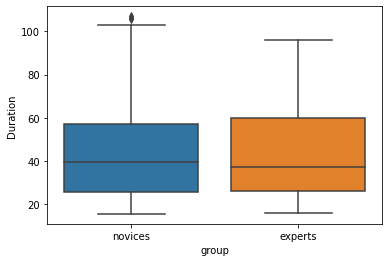

In [74]:
#create a violin plot comparing the Duration of novices and experts
sns.boxplot(x="group", y="Duration", data=df_behavioral)

In [199]:
df_behavioral.groupby("group")["Duration"].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
expert,469.0,55.469152,41.064863,4.215789,25.255712,42.046653,77.165128,180.076877
middle,439.0,53.534093,39.909116,5.707289,24.220098,42.071379,70.977094,180.075031
novice,137.0,63.543413,45.258711,5.690529,30.757360,50.637861,83.207245,180.079868


<AxesSubplot:xlabel='group', ylabel='count'>

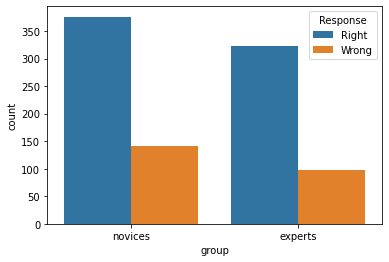

In [104]:
# create plot based on the group coulmn and the count of "Right" and "Wrong" in the response column
sns.countplot(x="group", hue="Response", data=df_behavioral)

In [106]:
# group df_behavioral based on groups and count the number of "Right" and "Wrong" in the response column
correctness = df_behavioral.groupby("group")["Response"].value_counts()

In [110]:
correctness["novices"]["Right"] / len(df_behavioral[df_behavioral["group"] == "novices"])

0.7258687258687259

In [111]:
correctness["experts"]["Right"] / len(df_behavioral[df_behavioral["group"] == "experts"])

0.7672209026128266

<h2> Prepare queried Data</h2>

In [38]:
def update_names(df_eyetracking, name_dict):
    df_eyetracking = df_eyetracking.rename(columns=name_dict)
    return df_eyetracking

In [39]:
def update_to_display_coordinates(df_eyetracking):
    df_eyetracking["display_x"] = df_eyetracking["display_x"].apply(lambda x: x * display_width)
    df_eyetracking["display_x"] = df_eyetracking["display_x"].astype(float).fillna(0).astype(int)

    df_eyetracking["display_y"] = df_eyetracking["display_y"].apply(lambda x: x * display_height)
    df_eyetracking["display_y"] = df_eyetracking["display_y"].astype(float).fillna(0).astype(int)
    return df_eyetracking

In [40]:
def update_normalize_time(df_eyetracking):
    df_eyetracking["time"] = df_eyetracking["time"] - df_eyetracking["time"][0]
    return df_eyetracking

In [41]:
def update_replace_invalid(df_eyetracking):
    (
        replaced_x,
        replaced_y,
        replaced_diameter,
        replaced_valid,
    ) = son.eyetracking.preprocessing_invalid.replace_with_prev_invalid(
        df_eyetracking["display_x"],
        df_eyetracking["display_y"],
        df_eyetracking["pupil_diameter"],
        df_eyetracking["valid"],
    )

    df_eyetracking["display_x"] = replaced_x
    df_eyetracking["display_y"] = replaced_y
    df_eyetracking["pupil_diameter"] = replaced_diameter
    df_eyetracking["valid"] = replaced_valid
    return df_eyetracking

In [42]:
def update_denoise(df_eyetracking, denoise_degree):
    for _i in range(denoise_degree):
        denoised_x, denoised_y = son.eyetracking.preprocessing_denoise.denoise(
            df_eyetracking["display_x"],
            df_eyetracking["display_y"],
            son.eyetracking.preprocessing_denoise.parabola_5_kernel,
        )

        df_eyetracking["display_x"] = denoised_x
        df_eyetracking["display_y"] = denoised_y
    return df_eyetracking

In [43]:
def update_match_to_line(df_eyetracking, line_middle, cat):
    df_eyetracking["display_y"] =  df_eyetracking["display_y"].apply(lambda x: line_middle[cat[x]] if cat[x] is not None else float("Nan"))
    df_eyetracking = df_eyetracking[df_eyetracking["display_y"].notnull()]
    df_eyetracking["display_y"] = df_eyetracking["display_y"].astype(int)
    df_eyetracking = df_eyetracking.reset_index()
    return df_eyetracking

In [50]:
def mask_function():
    return lambda height, width, coordinate: son.utils.masks.create_circular_mask(height, width, coordinate, 30)

def create_heatmap(df_eyetracking, color, width, height):
    heat_data = son.eyetracking.heatmap.create_heatmap(
        df_eyetracking["display_x"],
        df_eyetracking["display_y"],
        df_eyetracking["valid"],
        0.004,
        width,
        height,
        mask_function(),
    )

    heat_data = heat_data / heat_data.max()
    heat_data = np.array([heat_data * color[0], heat_data * color[1], heat_data * color[2], heat_data])
    heat_data = np.moveaxis(heat_data, 0, 2)
    return heat_data

In [ ]:
def create_sequence_diagram(df_eyetracking, color, width, height, max_pixel):
    step_size = max_pixel/len(df_eyetracking)

    sequence_data = son.eyetracking.sequence.create_sequence_diagram_y(
        df_eyetracking["display_y"],
        df_eyetracking["valid"],
        height,
        width,
        offset=0,
        step=step_size,
        should_skip=False,
    )
    sequence_data = np.array([sequence_data * color[0], sequence_data * color[1], sequence_data * color[2], sequence_data])
    sequence_data = np.moveaxis(sequence_data, 0, 2)
    return sequence_data

In [ ]:
def get_fixation_saccades_metrics(df_eyetracking, d_time):
    d_time = 0.004
    threshold_for_fixation = 2400.0
    saccades = son.eyetracking.metrics.classify_saccades( df_eyetracking["display_x"], df_eyetracking["display_y"], d_time, threshold_for_fixation)
    if len(saccades) >= 1:
        saccades[0] = saccades[1]


    fixxation = son.eyetracking.metrics.classify_fixxation( df_eyetracking["display_x"], df_eyetracking["display_y"], d_time, threshold_for_fixation)
    if len(fixxation) >= 1:
        fixxation[0] = fixxation[1]


    saccades = np.array(saccades)
    fixxation = np.array(fixxation)

    saccades_count = son.eyetracking.metrics.count_saccades(saccades)
    if saccades_count == 0:
        saccades_time_of_first = 0
        saccades_average_time = 0
    else:
        saccades_time_of_first = son.eyetracking.metrics.time_of_saccades(saccades, d_time)[0][0]
        saccades_average_time = son.eyetracking.metrics.average_saccades_time(son.eyetracking.metrics.time_of_saccades(saccades, d_time))

    fixxation_count = son.eyetracking.metrics.count_fixxations(fixxation)
    if fixxation_count == 0:
        fixxation_time_of_first = 0
        fixxation_average_time = 0
    else:
        fixxation_time_of_first = son.eyetracking.metrics.time_of_fixxations(fixxation, d_time)[0][0]
        fixxation_average_time = son.eyetracking.metrics.average_fixxations_time(son.eyetracking.metrics.time_of_fixxations(fixxation, d_time))

    return pd.DataFrame([[
        saccades_count,
        saccades_time_of_first,
        saccades_average_time,
        fixxation_count,
        fixxation_time_of_first,
        fixxation_average_time,
    ]], columns=["Saccades Count", "Time to first Saccade", "Average Saccade Time", "Fixation Count", "Time to first Fixation", "Average Fixation Time"])

In [47]:
df_eyetracking = data["BogoSort"]["Code"]["EyeTracking"][
    [
        "l_valid",
        "l_display_x",
        "l_display_y",
        "time",
        "l_pupil_diameter",
    ]
]

left_naming = {
    "l_valid" : "valid",
    "l_display_x" : "display_x",
    "l_display_y" : "display_y",
    "l_pupil_diameter" : "pupil_diameter",
}

right_naming = {
    "r_valid" : "valid",
    "r_display_x" : "display_x",
    "r_display_y" : "display_y",
    "r_pupil_diameter" : "pupil_diameter",
}

df_eyetracking = update_names(df_eyetracking, left_naming)
df_eyetracking = update_to_display_coordinates(df_eyetracking)
df_eyetracking = update_normalize_time(df_eyetracking)
df_eyetracking = update_replace_invalid(df_eyetracking)
df_eyetracking = update_denoise(df_eyetracking, denoise_degree)
df_eyetracking = update_match_to_line(df_eyetracking, line_middle, cat)